## Parte 0: Configuration and imports


In [16]:
# Package installation
!pip install kaggle
!pip install plotly

# librery import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import requests
from io import StringIO
import re
from datetime import datetime
import numpy as np
import plotly.express as px


## Part 1: Import and exploration of data set




In [17]:
# Download CSV from Google Drive
file_id = "1-5_JXOnscS2zN1nEgNVKJX5wFL4uLb1L"
download_link = f"https://drive.google.com/uc?id={file_id}"
response = requests.get(download_link)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data, encoding='utf-8')

In [18]:
# Configuration index and columns
df.set_index('Unnamed: 0', inplace=True)
df.index.name ="ID"

In [19]:
df.shape

(16130, 2)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16130 entries, 0 to 16129
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   time     16130 non-null  object
 1   comment  16130 non-null  object
dtypes: object(2)
memory usage: 378.0+ KB


In [21]:
df.describe()

,time,comment
count,16130,16130
unique,6451,13149
top,1:33:41,I was here
freq,16,298


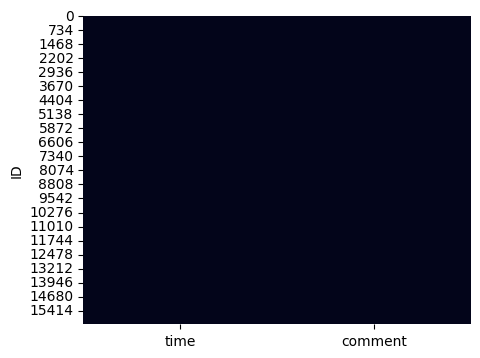

In [22]:
# Data null scan
plt.figure(figsize=(5, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

## Part 2: Data preprocessing and sentiment analysis

In [23]:

# Sentiment analysis
classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Function for sentiment analysis
def obtener_polaridad(comentario):
    resultado = classifier(comentario)
    return resultado[0]['label']

def extraer_numeros(texto):
    numeros = re.findall(r'\d+', texto)
    return int(numeros[0]) if numeros else None

# Apply function
df['polarity'] = df['comment'].apply(obtener_polaridad)
df['score'] = df['polarity'].apply(extraer_numeros)

# Categorization of feelings
df['POSITIVE'] = df['score'].apply(lambda x: 1 if x in [4, 5] else 0)
df['NEUTRAL'] = df['score'].apply(lambda x: 1 if x == 3 else 0)
df['NEGATIVE'] = df['score'].apply(lambda x: 1 if x in [1, 2] else 0)

# Selecting relevant columns
df = df[['time', 'POSITIVE', 'NEUTRAL', 'NEGATIVE']]
df['time'] = df['time'].astype(str)


<ipython-input-23-f133af9215e3>:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Part 3: Temporal Processing and Charting

In [24]:
# Temporal clustering
group_df = df.groupby('time').agg({
    'POSITIVE': 'sum',
    'NEUTRAL': 'sum',
    'NEGATIVE': 'sum'
}).reset_index()

# Time formatting
group_df["time"] = group_df["time"].apply(lambda x: re.sub(r'24:00', '00:00', x))
group_df["tiempo"] = pd.to_datetime(group_df["time"], errors='coerce')
filas_nat = group_df[group_df["tiempo"].isna()]
group_df = group_df.dropna(subset=["tiempo"]).sort_values(by="tiempo", ascending=True)
group_df = group_df[['tiempo', 'POSITIVE', 'NEUTRAL', 'NEGATIVE']]
group_df["tiempo"] = pd.to_datetime(group_df["tiempo"], errors='coerce')
group_df["tiempo"] = group_df["tiempo"].dt.strftime('%H:%M:%S').str.rstrip("0").str[:-1]

# Creation range of time
tiempo_range = pd.date_range(start="00:00:03", end="00:23:59", freq='S')
df2 = pd.DataFrame({'tiempo': tiempo_range})
df2['tiempo'] = pd.to_datetime(df2['tiempo']).dt.strftime('%M:%S').astype(str)

# Merging of data
def merge_and_add_data(row, df):
    tiempo_value = row['tiempo']
    matching_data = group_df[group_df['tiempo'] == tiempo_value][['POSITIVE', 'NEUTRAL', 'NEGATIVE']]
    return matching_data.values[0] if not matching_data.empty else [0, 0, 0]

merged_data = df2.apply(lambda row: merge_and_add_data(row, df), axis=1, result_type='expand')
df2[['POSITIVE', 'NEUTRAL', 'NEGATIVE']] = merged_data
df2['CUMULATIVE_POSITIVE'] = df2['POSITIVE'].cumsum()
df2['CUMULATIVE_NEUTRAL'] = df2['NEUTRAL'].cumsum()
df2['CUMULATIVE_NEGATIVE'] = df2['NEGATIVE'].cumsum()

# Creation of graphics
df_positive = df2[['tiempo', 'CUMULATIVE_POSITIVE']].rename(columns={'CUMULATIVE_POSITIVE': 'y'})
df_neutral = df2[['tiempo', 'CUMULATIVE_NEUTRAL']].rename(columns={'CUMULATIVE_NEUTRAL': 'y'})
df_negative = df2[['tiempo', 'CUMULATIVE_NEGATIVE']].rename(columns={'CUMULATIVE_NEGATIVE': 'y'})


## Part 4:Static graph generation

In [25]:
# Assign colors to each category when creating DataFrames
color_mapping = {'POSITIVE': 'green', 'NEUTRAL': 'white', 'NEGATIVE': 'red'}

df_positive['color'] = color_mapping['POSITIVE']
df_neutral['color'] = color_mapping['NEUTRAL']
df_negative['color'] = color_mapping['NEGATIVE']

# Concatenate the data sets
df = pd.concat([df_positive, df_neutral, df_negative], keys=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

# Creation static graphics
fig_total = px.line(df, x='tiempo', y='y', color='color', range_x=[0, 6], range_y=[0, 3],
                    line_dash='color', color_discrete_sequence=['green', 'white', 'red'])

# graphics config.
fig_total.update_layout(
    title='HISTORIAL EVOLUTION',
    xaxis_title='time',
    yaxis_title='n° of sentences',
    template='plotly_dark',
    xaxis=dict(showgrid=True, gridcolor='rgba(255, 255, 255, 0.1)'),
    yaxis=dict(showgrid=True, gridcolor='rgba(255, 255, 255, 0.1)'),
    height=800,
    width=1600
)
fig_total.show()

## Parte 5:Generacion de grafico dinamico

In [26]:
df11=pd.DataFrame({
    "Tiempo": df_positive["tiempo"],
    "Acumulado": df_positive["y"] ,
})
df11['x'] = 1.5
df11['y'] = 8


df22=pd.DataFrame({
    "Tiempo": df_neutral["tiempo"],
    "Acumulado": df_neutral["y"] ,
})
df22['x'] = 2
df22['y'] = 4


df33=pd.DataFrame({
    "Tiempo": df_negative["tiempo"],
    "Acumulado": df_negative["y"] ,
})
df33['x'] = 2.5
df33['y'] = 9


# Add colors and simbols.
df11['Color'] = 'green'
df11['Symbol'] = 'circle'
df22['Color'] = 'white'
df22['Symbol'] = 'circle'
df33['Color'] = 'red'
df33['Symbol'] = 'circle'

# Concatenate the data sets
df = pd.concat([df11, df22, df33], keys=['Conjunto1', 'Conjunto2', 'Conjunto3'])

# Create the animated graph with variable size
fig = px.scatter(df, x='x', y='y', animation_frame='Tiempo', size='Acumulado',
                 color='Color', range_x=[0, 4], range_y=[0, 4], size_max=250,
                 color_discrete_map={'red': 'red', 'green': 'green', 'white': 'white'}, symbol='Symbol', text='Acumulado')
# Customize animation and layout
fig.update_layout(
    title='EVOLUTION OF COMMENTS',
    template='plotly_dark',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    height=900  # adjust height
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.